In [1]:
import cv2
import numpy as np
import params,utils
import os
import pickle

#按批次读取数据
class VidDataGenerator():
    def __init__(self,img_path,batch_id,batch_size=None,input_shape=(224,224,3),train_ratio=1):
        self.img_path = img_path
        self.batch_id = batch_id
        self.batch_size = batch_size
        self.current_frame = 0
        self.input_shape = input_shape
        self.train_ratio = train_ratio
        self.vid_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mkv'.format(self.batch_id))
        print('Training:',self.vid_path)
        
    def next_batch(self):
        #标注处理
        label_all = utils.get_human_steering(self.batch_id)
        if(self.batch_size == None):
            self.batch_size = len(label_all)
            
        label = utils.get_human_steering(self.batch_id)[self.current_frame:self.current_frame+self.batch_size]
        labels = [[label[i]] for i in range(len(label))]
        labels = np.array(labels)
        #图像处理        
        
        cap = cv2.VideoCapture(self.vid_path)
        nframe = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) - 2)
        if( (self.current_frame+self.batch_size) > nframe):
            self.batch_size = nframe - self.current_frame
        images = []
        for i in range(self.current_frame,self.current_frame+self.batch_size):
            utils.cv2_goto_frame(cap,i) 
            ret, frame = cap.read()
            if (ret == True):
                shape = frame.shape
                frame = frame[int(shape[0]/3):shape[0]-150, 0:shape[1]]
                frame = cv2.resize(frame, (self.input_shape[0], self.input_shape[1]), interpolation=cv2.INTER_AREA)
                frame = np.resize(frame, (self.input_shape[0], self.input_shape[1], self.input_shape[2]))
                images.append(frame)
                del frame
        images = np.array(images)    
        self.current_frame = utils.cv2_current_frame(cap)
        cap.release()

        return (images[:int(self.batch_size*self.train_ratio)],labels[:int(self.batch_size*self.train_ratio)],
                images[int(self.batch_size*self.train_ratio):],labels[int(self.batch_size*self.train_ratio):])

Using TensorFlow backend.


Training: C:\machinelearning\epochs\epoch04_front.mkv
Shape:x = (64, 64, 64, 3) y = (64, 1)


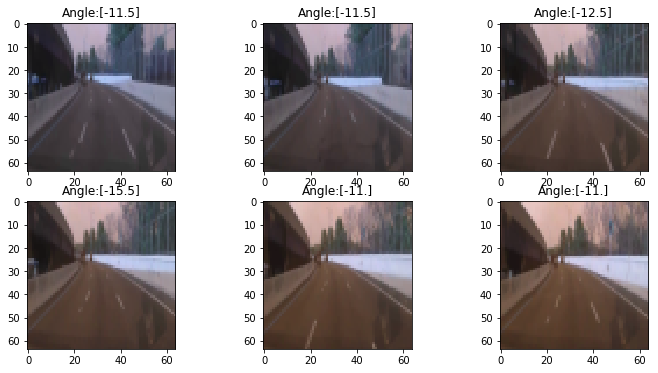

In [6]:
#Test
from matplotlib import pyplot as plt
%matplotlib inline
img_path = params.data_dir
input_shape=(64, 64, params.FLAGS.img_c)
x_test,y_test,_,_ = VidDataGenerator(img_path,'04',batch_size=64,input_shape=input_shape).next_batch()
assert len(x_test)==len(y_test)
print('Shape:x =',x_test.shape,'y =',y_test.shape)
plt.figure(figsize=(12, 6))
plt.axis('off')
plt.subplot(231)
plt.imshow(x_test[10])
plt.title('Angle:'+str(y_test[10]))
plt.subplot(232)
plt.imshow(x_test[20])
plt.title('Angle:'+str(y_test[20]))
plt.subplot(233)
plt.imshow(x_test[30])
plt.title('Angle:'+str(y_test[30]))
plt.subplot(234)
plt.imshow(x_test[40])
plt.title('Angle:'+str(y_test[40]))
plt.subplot(235)
plt.imshow(x_test[50])
plt.title('Angle:'+str(y_test[50]))
plt.subplot(236)
plt.imshow(x_test[60])
plt.title('Angle:'+str(y_test[60]))
plt.show()

12.5 -14.5


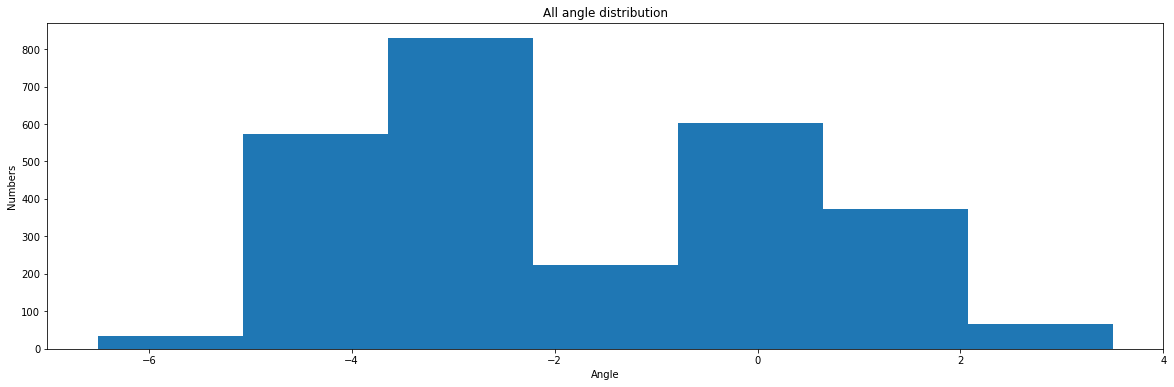

In [31]:
#标注数据可视化展示
labels = []
for i in ['01','02','03','04','05','06','07','08','09','10']:
    label = utils.get_human_steering(i)
    if(len(labels)==0):
        labels=label
    else:
        labels.extend(label)

print(labels[np.argmax(labels)-10],labels[np.argmin(labels)-10])

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)
ax.hist(label, bins=7)
plt.title('All angle distribution')
plt.xlabel('Angle')
plt.ylabel('Numbers')
plt.show()

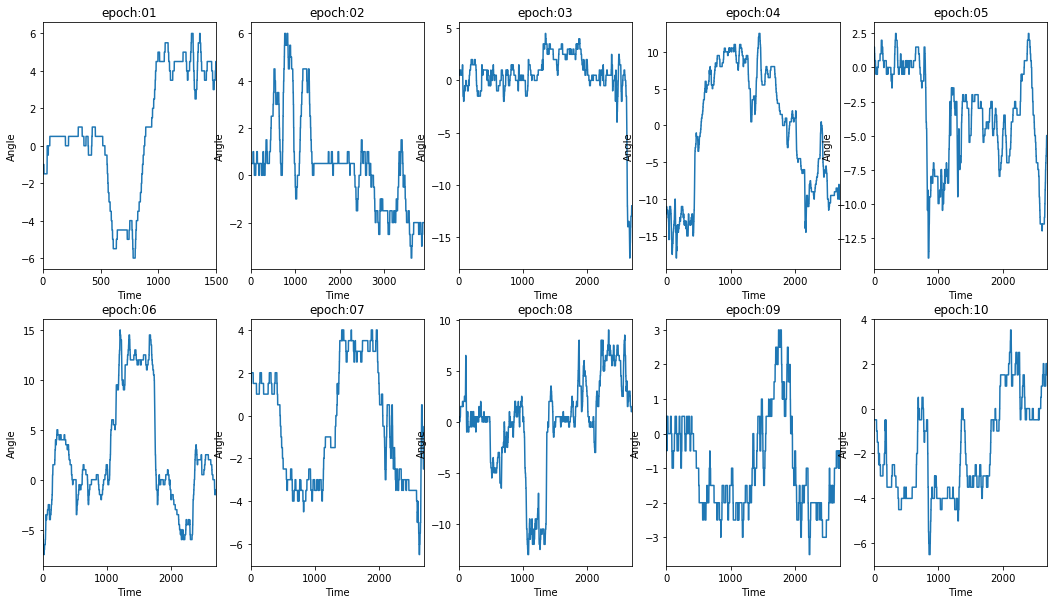

In [56]:
#标注数据可视化展示
import pandas as pd
plt.figure(figsize=(18, 10))
plt.axis('off')
for i in ['01','02','03','04','05','06','07','08','09','10']:
    label = utils.get_human_steering(i)
    var = pd.Series(label)
    plt.subplot(2,5,int(i))
    plt.title('epoch:'+str(i))
    plt.xlabel('Time')
    plt.ylabel('Angle')
    var.plot(kind='line')

plt.show()

In [ ]:
#生成器
def train_generator(img_path,epochs):
    for i in epochs:
        try:
            file_name = utils.join_dir(img_path, 'epoch{:0>2}.pkl'.format(i))
            with open(file_name,'rb') as fs:
                x_train,y_train = pickle.load(fs)
                yield x_train,y_train
        except StopIteration as e:
            break

In [ ]:
#生成测试文件
def save_train_file():
    img_path = params.data_dir
    batch_size = None
    input_shape=(params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c)
    #for i in ['01','02','03','04','05','06','07','08','09','10']:
    for i in ['02']:
        file_name = utils.join_dir(img_path, 'epoch{:0>2}.pkl'.format(i))
        if(os.path.exists(file_name)):
            print(file_name,'Already exist')
            break
        train_data= VidDataGenerator(img_path=img_path,batch_id=i,batch_size=batch_size,input_shape=input_shape)
        x_train,y_train,_,_ = train_data.next_batch()
        
        with open(file_name,'wb') as fs:
            pickle.dump((x_train,y_train),fs)
        print('Save '+ file_name)
        
save_train_file()

In [2]:
#vgg16模型改造
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Input
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Lambda

def vgg16_model(input_shape):
    inputs = Input(shape=input_shape)
    lambda_input = Lambda(lambda x:x/255,name='Lambda')(inputs)
    base_model = VGG16(include_top=False, weights='imagenet',input_tensor=lambda_input)
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = Flatten(name='flatten')(x)
    x = Dense(1164, activation='relu', name='fc1')(x)
    x = Dropout(0.5,name='fc1_dropout')(x)
    x = Dense(100, activation='relu', name='fc2')(x)
    x = Dropout(0.5,name='fc2_dropout')(x)
    x = Dense(50, activation='relu', name='fc3')(x)
    x = Dropout(0.5,name='fc3_dropout')(x)
    x = Dense(10, activation='relu', name='fc4')(x)
    x = Dropout(0.5,name='fc4_dropout')(x)
    x = Dense(1,name='output')(x)
    
    model = Model(inputs,x)
    return model

In [ ]:
from keras.models import Model
from keras.layers import Input,Conv2D,Lambda,MaxPooling2D,Flatten,Dense
def nvidia_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Lambda(lambda x:x/255,name='Lambda')(inputs)
    
    x = Conv2D(24, (5, 5), activation='relu', padding='same', name='block1_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    x = Conv2D(36, (5, 5), activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    x = Conv2D(48, (5, 5), activation='relu', padding='same', name='block3_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1164, activation='relu', name='fc1')(x)
    x = Dropout(0.5,name='fc1_dropout')(x)
    x = Dense(100, activation='relu', name='fc2')(x)
    x = Dropout(0.5,name='fc2_dropout')(x)
    x = Dense(50, activation='relu', name='fc3')(x)
    x = Dropout(0.5,name='fc3_dropout')(x)
    x = Dense(10, activation='relu', name='fc4')(x)
    x = Dropout(0.5,name='fc4_dropout')(x)
    x = Dense(1,name='output')(x)
    
    model = Model(inputs,x)
    return model

In [ ]:
from keras.layers import Convolution2D
from keras.models import Sequential
def nvidia_model2(input_shape):
    model = Sequential()
    model.add(Lambda(lambda x:x/255, input_shape=input_shape))
    model.add(Convolution2D(24,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
    model.add(Convolution2D(36,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
    model.add(Convolution2D(48,5,5,border_mode='valid', activation='relu', subsample=(2,2)))
    model.add(Convolution2D(64,3,3,border_mode='valid', activation='relu', subsample=(1,1)))
    model.add(Convolution2D(64,3,3,border_mode='valid', activation='relu', subsample=(1,1)))
    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    
    return model

In [ ]:
#训练模型1
from keras import optimizers
import h5py

img_path = params.data_dir
batch_size = None
input_shape=(params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c)
model = nvidia_model(input_shape=input_shape)
sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='mean_squared_error',
               optimizer=adam,
               metrics=['accuracy'])

model.summary()

model.fit_generator(train_generator(img_path,['01']),
                    steps_per_epoch=10,
                    epochs=10)

In [3]:
#训练模型2
from keras.callbacks import TensorBoard,EarlyStopping,CSVLogger
from keras import optimizers
import h5py

img_path = params.data_dir
batch_size = None
input_shape=(params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c)
model = vgg16_model(input_shape=input_shape)
sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='mean_squared_error',
               optimizer=adam)

model.summary()
with open(utils.join_dir(img_path, 'epoch{:0>2}.pkl'.format('09')),'rb') as fs:
        x_valid,y_valid = pickle.load(fs)

i = 0
for epochid in ['01','02','03','04','05','06','07','08']:
#for epochid in ['01','02','03','07','09']:
    file_name = utils.join_dir(img_path, 'epoch{:0>2}.pkl'.format(epochid))
    with open(file_name,'rb') as fs:
        x_train,y_train = pickle.load(fs)
        if(i==0):
            x = x_train
            y = y_train
            i=1
        else:
            x=np.concatenate((x,x_train))
            y=np.concatenate((y,y_train))
            
        if(len(x) == 0):
            break
print(x.shape,y.shape)

model.fit(x, y,epochs=20,batch_size=128,validation_data=(x_valid,y_valid),shuffle=True,
                  callbacks=[TensorBoard(log_dir='./log'),
                             EarlyStopping(monitor='loss', patience=5, verbose=0, mode='auto'),
                            CSVLogger(filename='./log/csv.log', separator=',', append=False)])
    
utils.save_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
Lambda (Lambda)              (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
__________

In [8]:
#训练模型3
from keras.callbacks import TensorBoard,EarlyStopping,CSVLogger
from keras import optimizers
import h5py

img_path = params.data_dir
batch_size = None
input_shape=(params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c)
model = vgg16_model(input_shape=input_shape)
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='mean_squared_error',
               optimizer=adam)

model.summary()
with open(utils.join_dir(img_path, 'epoch{:0>2}.pkl'.format('09')),'rb') as fs:
        x_valid,y_valid = pickle.load(fs)

i = 0
for epochid in ['01','02','03','04','05','06','07','08']:
    file_name = utils.join_dir(img_path, 'epoch{:0>2}.pkl'.format(epochid))
    with open(file_name,'rb') as fs:
        x_train,y_train = pickle.load(fs)
        model.fit(x_train, y_train,epochs=50,batch_size=128,validation_data=(x_valid,y_valid),shuffle=True,
                  callbacks=[TensorBoard(log_dir='./log'),
                             EarlyStopping(monitor='loss', patience=5, verbose=0, mode='auto'),
                            CSVLogger(filename='./log/csv.log', separator=',', append=False)])
    
utils.save_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
Lambda (Lambda)              (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
__________

2700/2700 [==============================] - 169s 63ms/step - loss: 23.0622 - val_loss: 11.5259
Epoch 17/50
2700/2700 [==============================] - 172s 64ms/step - loss: 20.5335 - val_loss: 12.1817
Epoch 18/50
2700/2700 [==============================] - 172s 64ms/step - loss: 21.3298 - val_loss: 11.9529
Epoch 19/50
2700/2700 [==============================] - 168s 62ms/step - loss: 21.9504 - val_loss: 12.9842
Epoch 20/50
2700/2700 [==============================] - 170s 63ms/step - loss: 22.1631 - val_loss: 10.9074
Epoch 21/50
2700/2700 [==============================] - 168s 62ms/step - loss: 20.7122 - val_loss: 9.0027
Epoch 22/50
2700/2700 [==============================] - 172s 64ms/step - loss: 20.3440 - val_loss: 8.7594
Epoch 23/50
2700/2700 [==============================] - 181s 67ms/step - loss: 21.5525 - val_loss: 9.8254
Epoch 24/50
2700/2700 [==============================] - 171s 63ms/step - loss: 20.4710 - val_loss: 11.3903
Epoch 25/50
2700/2700 [====================

Model already exists, do you want to reuse? (y/n): y
Model fetched from the disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
Lambda (Lambda)              (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_____________________________________________________________

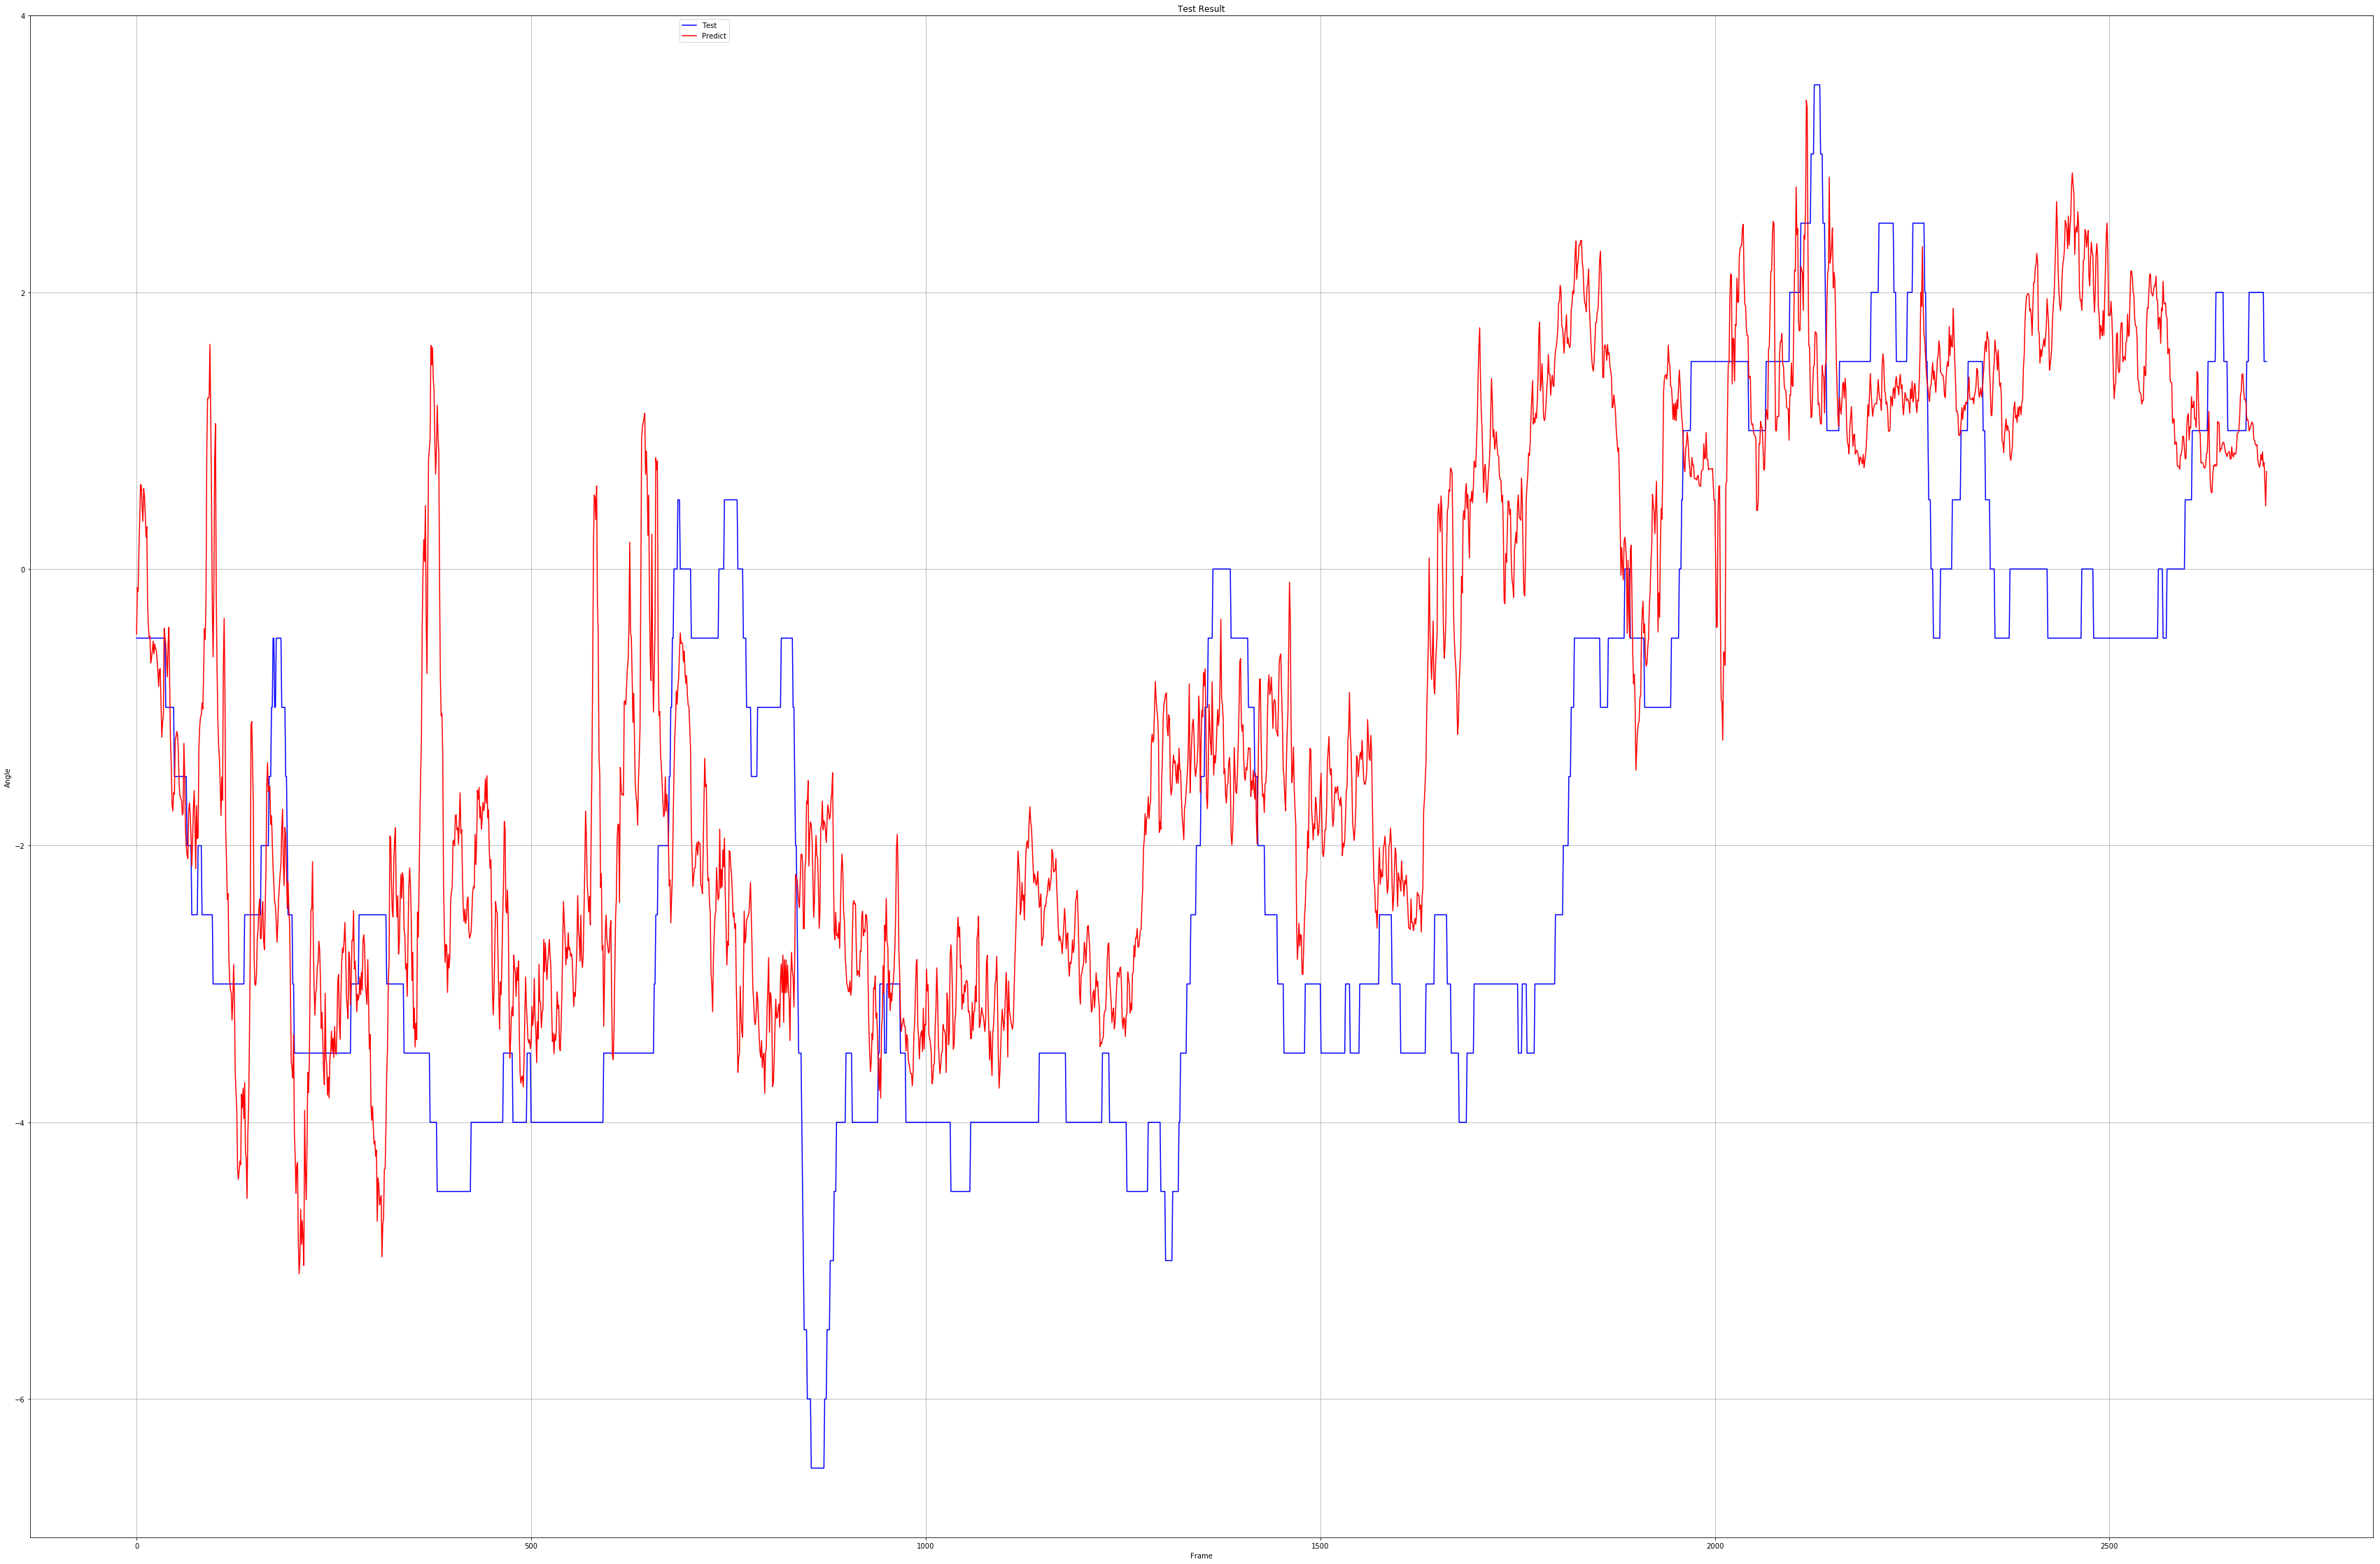

In [34]:
#测试模型
import params,utils
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
%matplotlib inline

img_path = params.data_dir
input_shape=(params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c)
#x_test,y_test,_,_ = VidDataGenerator(img_path,'10',batch_size=None,input_shape=input_shape).next_batch()
with open(utils.join_dir(img_path, 'epoch{:0>2}.pkl'.format('10')),'rb') as fs:
        x_test,y_test = pickle.load(fs)
 
  

model = utils.get_model()
y_predict = model.predict(x_test)
score = r2_score(y_test,y_predict)
print('Score:',score)
plt.figure(figsize=(60, 40))
plt.title('Test Result')
plt.xlabel('Frame')
plt.ylabel('Angle')

plt.plot(range(len(y_test)), y_test.reshape(len(y_test)),'b', label='Test')  
plt.plot(range(len(y_predict)), y_predict.reshape(len(y_predict)),'r',label='Predict')  
#plt.xticks(range(len(y_test), group_labels, rotation=0)  
  
plt.legend(bbox_to_anchor=[0.3, 1])  
plt.grid()  
plt.show()  

In [3]:
#生成模型图
from keras.utils import plot_model
model = utils.get_model()
plot_model(model, to_file='model.png')


Model already exists, do you want to reuse? (y/n): y
Model fetched from the disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
Lambda (Lambda)              (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_____________________________________________________________

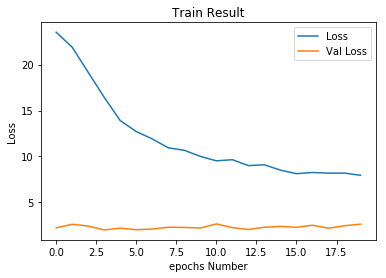

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
rows = pd.read_csv('./log/csv.log')
y1=list(rows.loss.values)
x1=range(0,len(y1)) 
y2=list(rows.val_loss.values)
x2=range(0,len(y2)) 
plt.plot(x1,y1,label='Loss') 
plt.plot(x2,y2,label='Val Loss') 
plt.xlabel('epochs Number') 
plt.ylabel('Loss') 
plt.title('Train Result') 
plt.legend() 
plt.show() 